# Make full results including systematic uncertainties
This notebooks can calculate plots equivalent to the bias calculations in the last section of the paper (although not with the Belle 2018 amplitude model in this, public version).

In order for it to work, the studies for which results are fetched need to have been run, using the scripts in the `/scripts/` directory.


In [1]:
import numpy as np
# this is Oxford specific of course ...
study_dir = '/data/lhcb/users/bjoern/Analyses/B2DPi/data/various_studies/ks_cpv/simple_full_studies'
default_model = 'EvtGen'
alternative_models = ['EvtGen']
# setup = 'Belle2018'
experiments = ['LL_lhcb', 'DD_lhcb', 'VDX_belle']
n_KL = 5
num_iv = 2

## Load base results and KL uncertainties

In [2]:
import cPickle, os
from BiasStudy import BiasStudy
import pandas as pd
import os, time

models = ['full', 'eps_only', 'mat_only']

bs_df = pd.DataFrame(columns=['model', 'effect','experiment','iv_num','modifier', 'param', 'bias_mean', 'bias_spread', 'bias', 'bias_w'])

def load_iv_bias(model, experiment, effect='full', iv_num=0, n_KL=50, modifier='', print_timestamp=False):
    bs = BiasStudy(empty=True)
    file_suffix = 'iv_{}_{}'.format(iv_num, effect)
    setup = 'setup_{}_{}{}_n_{}'.format(model, experiment, modifier, n_KL)
    bs.load_yields('{}/{}/iv_yields_{}.pickle'.format(study_dir, setup, file_suffix))
    bs.load_results('{}/{}/iv_results_{}.pickle'.format(study_dir, setup, file_suffix))
    bs.load_params('{}/{}/iv_params_{}.pickle'.format(study_dir, setup, file_suffix))
    
    if print_timestamp:
        print 'results saved:', time.ctime(os.path.getmtime('{}/{}/iv_results_{}.pickle'.format(study_dir, setup, file_suffix)))
    
    dfs = []
    def add_row(bs, param='gamma'):
        x = bs.get_results(param, KL_results="avg")[0]
        x_all = bs.get_results(param, KL_results="all")
        x_ws = bs.get_results(param, KL_results="weights")
        x_std = bs.get_results(param, KL_results="std")[0]

        param_name = param
        if param_name == 'gamma':
            param_name = 'g'
        
        dfs.append(pd.DataFrame([[model, effect, experiment, iv_num, modifier, param_name, x, x_std, x_all, x_ws]],
                          columns = bs_df.columns))
    add_row(bs, 'gamma')
    add_row(bs, 'r')
    add_row(bs, 'd')
    for xy_i, xy in enumerate(['xm', 'ym', 'xp', 'yp']):
        add_row(bs, xy)
    return pd.concat(dfs, ignore_index=True)

df = load_iv_bias('Belle2018', 'LL_lhcb')
print df.head()

       model effect experiment  iv_num modifier param  bias_mean  bias_spread  \
0  Belle2018   full    LL_lhcb       0              g   0.030737     0.002283   
1  Belle2018   full    LL_lhcb       0              r  -0.000001     0.000009   
2  Belle2018   full    LL_lhcb       0              d   0.027519     0.003798   
3  Belle2018   full    LL_lhcb       0             xm   0.000028     0.000012   
4  Belle2018   full    LL_lhcb       0             ym   0.000060     0.000003   

                                                bias  \
0  [[0.03047077298039369], [0.031938174291667565]...   
1  [[4.778475320724174e-06], [-2.0438847707221486...   
2  [[0.02406748053545016], [0.025232275805734616]...   
3  [[3.470162804872223e-05], [3.2839662495516564e...   
4  [[5.7364417194588624e-05], [5.5726180798520986...   

                                              bias_w  
0  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....  
1  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....  
2  [[1.0], 

## The single input value bias studies

## Model uncertainty
We take the difference between the minimum and maximum bias found in the default and alternative models as the model related uncertainty. The comparison is done seperately for each experiment and input parameter set

loading iv 0 results
results saved: Tue Mar 26 11:54:30 2019
loading iv 0 results
results saved: Tue Mar 26 11:59:16 2019
loading iv 0 results
results saved: Tue Mar 26 11:54:20 2019
loading iv 1 results
results saved: Thu Mar 28 10:10:53 2019
loading iv 1 results
results saved: Thu Mar 28 10:11:46 2019
loading iv 1 results
results saved: Thu Mar 28 10:11:48 2019
Plot of all biases! Do they look reasonable?


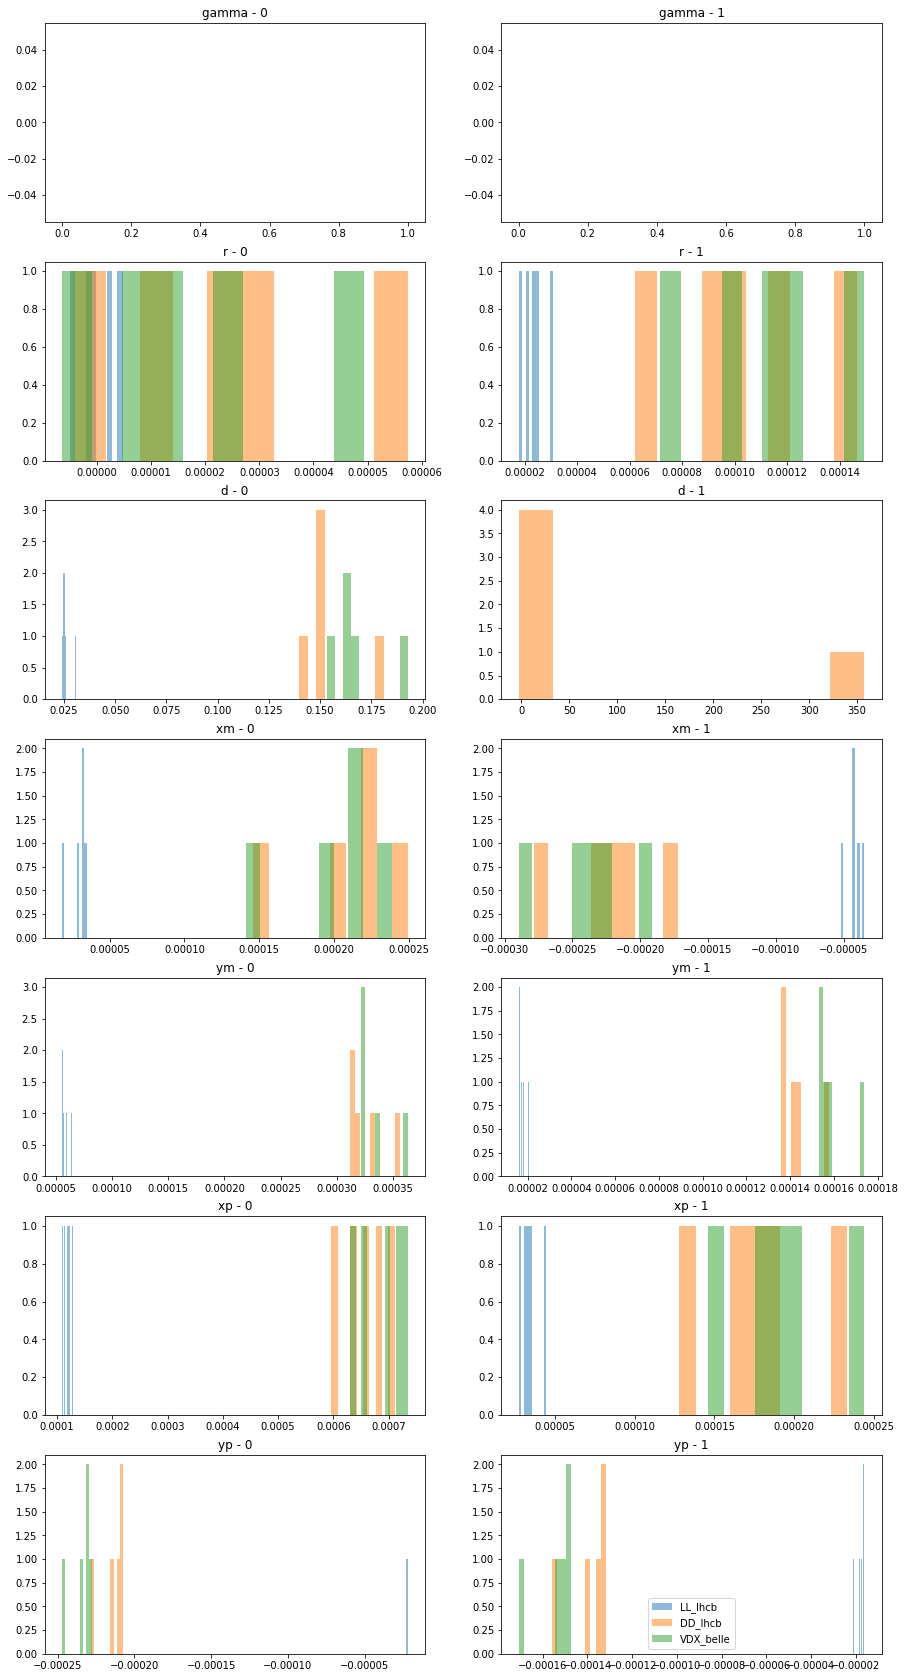

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import UtilityFunctions as uf
param = ["gamma", "xm", "ym", "xp", "yp", "r", "d"]
from matplotlib import rcParams, rc
rc('text', usetex=False) 
dfs = []




for e in experiments:
    print 'loading iv 0 results'
    for c in ['full', 'mat_only', 'eps_only']:
        df = load_iv_bias(default_model, e, c, iv_num=0, n_KL=n_KL, print_timestamp=(c=='full'))
        dfs.append(df)

        
for e in experiments:
    print 'loading iv 1 results'
    for c in ['full', 'mat_only', 'eps_only']:
        df = load_iv_bias(default_model, e, c, iv_num=1, n_KL=5, print_timestamp=(c=='full'))
        dfs.append(df)
        
bs_df = pd.concat(dfs, ignore_index=True)

fig, ax = plt.subplots(7, 2, figsize=(15, 30))
print "Plot of all biases! Do they look reasonable?"
for ip, p in enumerate(['gamma', 'r', 'd', 'xm', 'ym', 'xp', 'yp']):
    for i in range(num_iv):
        for e in experiments:
            ax[ip, i].hist(bs_df[(bs_df.effect == 'full') & (bs_df.param == p) & (bs_df.model == default_model) 
                                 & (bs_df.experiment == e) &  (bs_df.iv_num == i)].bias, 
                           alpha=0.5, label=e)
            ax[ip, i].set_title('{} - {}'.format(p, i))
        plt.legend()
    
# make a smaller version for easier handling when not needing everything
def reduce(bs_df):

    return bs_df[['model', 'experiment','iv_num', 'param', 'effect', 'bias_mean', 'bias_spread', 'modifier']]
    
bs_reduced = reduce(bs_df)

In [4]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=False) 

dfs = []
for a in ['EvtGen', 'Belle2018', 'Belle2010']:
    for e in experiments:
        print 'loading iv 0, ex:', e
        for c in ['full', 'mat_only', 'eps_only']:
            df = load_iv_bias(a, e, effect=c, iv_num=0, n_KL=n_KL, print_timestamp=(c=='full'))
            dfs.append(df)
    print '-'
    for e in experiments:
        print 'loading iv 1, ex:', e
        for c in ['full', 'mat_only', 'eps_only']:
            df = load_iv_bias(a, e, effect=c, iv_num=1, n_KL=5, print_timestamp=(c=='full'))
            dfs.append(df)

bs_model = reduce(pd.concat(dfs))


model_err = bs_model.groupby(['experiment', 'effect','iv_num', 'param'])['bias_mean'].agg([np.min, np.max])
model_err['model_err'] = model_err.amax - model_err.amin
model_err = model_err.reset_index()
print model_err[(model_err.effect=='full') & (model_err.experiment=='VDX_belle')]

loading iv 0, ex: LL_lhcb
results saved: Tue Mar 26 11:57:11 2019
loading iv 0, ex: DD_lhcb
results saved: Tue Mar 26 11:59:19 2019
loading iv 0, ex: VDX_belle
results saved: Tue Mar 26 11:59:22 2019
-
loading iv 1, ex: LL_lhcb
results saved: Thu Mar 28 10:10:52 2019
loading iv 1, ex: DD_lhcb
results saved: Thu Mar 28 10:11:34 2019
loading iv 1, ex: VDX_belle
results saved: Thu Mar 28 10:10:56 2019
loading iv 0, ex: LL_lhcb
results saved: Tue Mar 26 11:54:30 2019
loading iv 0, ex: DD_lhcb
results saved: Tue Mar 26 11:59:16 2019
loading iv 0, ex: VDX_belle
results saved: Tue Mar 26 11:54:20 2019
-
loading iv 1, ex: LL_lhcb
results saved: Thu Mar 28 10:10:53 2019
loading iv 1, ex: DD_lhcb
results saved: Thu Mar 28 10:11:46 2019
loading iv 1, ex: VDX_belle
results saved: Thu Mar 28 10:11:48 2019
loading iv 0, ex: LL_lhcb
results saved: Tue Mar 26 11:57:19 2019
loading iv 0, ex: DD_lhcb
results saved: Tue Mar 26 11:59:24 2019
loading iv 0, ex: VDX_belle
results saved: Tue Mar 26 11:59:29 2

In [5]:
print model_err[(model_err.effect=='full') & (model_err.param=='g')]

    experiment effect  iv_num param      amin      amax  model_err
15     DD_lhcb   full       0     g  0.166408  0.206681   0.040272
22     DD_lhcb   full       1     g  0.294374  0.558117   0.263743
57     LL_lhcb   full       0     g  0.024427  0.031246   0.006819
64     LL_lhcb   full       1     g  0.067293  0.116747   0.049454
99   VDX_belle   full       0     g  0.175858  0.215073   0.039215
106  VDX_belle   full       1     g  0.229472  0.591952   0.362479


In [6]:
# Just to check that the above group by works correctly
print bs_model[(bs_model.effect=='full') & (bs_model.experiment=='VDX_belle') & (bs_model.iv_num==1) & (bs_model.param=='g')]


       model experiment  iv_num param effect  bias_mean  bias_spread modifier
0     EvtGen  VDX_belle       1     g   full   0.229472     0.201945         
0  Belle2018  VDX_belle       1     g   full   0.422217     0.067588         
0  Belle2010  VDX_belle       1     g   full   0.591952     0.132344         


## KL parameter uncertainty
this is already saved, basically, as the spread

In [7]:
kl_err = bs_reduced[['experiment', 'iv_num','effect', 'bias_spread']]
kl_err.columns = ['experiment', 'iv_num', 'effect','KL_err']


## The $\rho$ and $z_{max}$ uncertainties

In [8]:
def modifier_err(mod, name):
    dfs = []
    for m in ['_{}m{}'.format(mod, x) for x in [ 0.9, 1.1]]:

        for e in experiments:
            for c in ['full', 'eps_only', 'mat_only']:
                df = load_iv_bias(default_model, e, c, iv_num=0, modifier=m, n_KL=n_KL)
                dfs.append(df)
                
        for e in experiments:
            for c in ['full', 'eps_only', 'mat_only']:
                df = load_iv_bias(default_model, e, c, iv_num=1, modifier=m, n_KL=5)
                dfs.append(df)

    bs_model = reduce(pd.concat(dfs))
    bs_model = pd.concat([bs_model, bs_reduced])

    err = bs_model.groupby(['experiment', 'effect', 'iv_num', 'param'], as_index=False)['bias_mean'].agg([np.min, np.max])
    err['{}_err'.format(name)] = err.amax - err.amin
    err = err.reset_index()
    return err, bs_model

rho_err, bs_rho = modifier_err('r', 'rho')

In [9]:
z_err, bs_z = modifier_err('z', 'z')

In [10]:
z_err

,experiment,effect,iv_num,param,amin,amax,z_err
0,DD_lhcb,eps_only,0,d,0.057768,0.069279,1.151167e-02
1,DD_lhcb,eps_only,0,g,0.047026,0.060994,1.396821e-02
2,DD_lhcb,eps_only,0,r,-0.000035,-0.000034,5.295505e-07
3,DD_lhcb,eps_only,0,xm,0.000029,0.000044,1.498205e-05
4,DD_lhcb,eps_only,0,xp,0.000307,0.000362,5.465410e-05
5,DD_lhcb,eps_only,0,ym,0.000150,0.000177,2.758462e-05
6,DD_lhcb,eps_only,0,yp,0.000008,0.000018,1.061826e-05
7,DD_lhcb,eps_only,1,d,-0.912631,-0.738390,1.742411e-01
8,DD_lhcb,eps_only,1,g,0.286861,0.322131,3.526969e-02
9,DD_lhcb,eps_only,1,r,0.000091,0.000100,9.932768e-06


## Momentum uncertainty

In [11]:
from MultimodelBiasStudy import MultimodelBiasStudy

def load_p_avg_bias(model, experiment, q_val, case = 'full', iv_num = 0, n_KL = 50):
    bs = MultimodelBiasStudy(empty=True)
    bs.load('{}/setup_{}_{}_q{}_n_{}/momentum_avg_iv_{}_{}.pickle'.format(
        study_dir, model, experiment, q_val, n_KL, iv_num, case))
    
    dfs = []
    for p in ['g', 'r', 'd', 'xm', 'ym', 'xp', 'yp']:
         dfs.append(bs.get_results(p))
    return pd.concat(dfs)
    


dfs = []
for q in [5, 10]:
    for e in experiments:
        for c in ['full', 'eps_only', 'mat_only']:
            df = load_p_avg_bias('Belle2018', e, q, c)
            df['q']=q
            df['experiment']=e
            df['effect']=c
            dfs.append(df)

bs_momentum = pd.concat(dfs)
bs_momentum = bs_momentum.reset_index()
p_err = bs_momentum.pivot_table(index=['experiment', 'effect', 'param'], columns='q', values='bias_mean').reset_index()
p_err['p_err'] = abs(p_err[5]-p_err[10])
p_err['iv_num'] = 0
p_err = p_err[['experiment', 'effect', 'iv_num', 'param', 'p_err']]

p_err_2 = p_err.copy()
p_err_2.iv_num = 1

p_err = pd.concat([p_err, p_err_2])


In [12]:
p_err

q,experiment,effect,iv_num,param,p_err
0,DD_lhcb,eps_only,0,d,1.323051e-03
1,DD_lhcb,eps_only,0,g,3.985484e-03
2,DD_lhcb,eps_only,0,r,3.867208e-06
3,DD_lhcb,eps_only,0,xm,6.055149e-06
4,DD_lhcb,eps_only,0,xp,5.872283e-07
5,DD_lhcb,eps_only,0,ym,4.864288e-07
6,DD_lhcb,eps_only,0,yp,9.692987e-06
7,DD_lhcb,full,0,d,1.097432e-03
8,DD_lhcb,full,0,g,3.802550e-03
9,DD_lhcb,full,0,r,3.914244e-06


# Uncertainty summary

In [13]:
err = pd.merge(model_err, p_err, on=['experiment','param','effect', 'iv_num'])
err = pd.merge(err, z_err, on=['experiment','param','effect', 'iv_num'])
err = pd.merge(err, rho_err, on=['experiment','param','effect', 'iv_num'])
err = err[['experiment', 'param', 'effect', 'iv_num', 'model_err',  'p_err', 'z_err', 'rho_err']]
err['err_except_KL'] = np.sqrt(err.model_err**2 + err.p_err**2 + err.z_err**2 + err.rho_err**2)


In [14]:
err[(err.iv_num==0) & (err.effect=='full')]

,experiment,param,effect,iv_num,model_err,p_err,z_err,rho_err,err_except_KL
14,DD_lhcb,d,full,0,0.040513,1.097432e-03,2.559159e-02,0.018231,0.051282
15,DD_lhcb,g,full,0,0.040272,3.802550e-03,4.135253e-02,0.028998,0.064709
16,DD_lhcb,r,full,0,0.000078,3.914244e-06,1.545578e-05,0.000012,0.000081
17,DD_lhcb,xm,full,0,0.000063,5.310959e-06,5.206802e-05,0.000035,0.000089
18,DD_lhcb,xp,full,0,0.000012,2.196027e-06,9.769402e-05,0.000064,0.000118
19,DD_lhcb,ym,full,0,0.000131,1.751507e-06,5.006932e-05,0.000032,0.000144
20,DD_lhcb,yp,full,0,0.000142,1.105520e-05,6.048143e-05,0.000045,0.000161
56,LL_lhcb,d,full,0,0.006780,1.797369e-04,5.297934e-03,0.003537,0.009305
57,LL_lhcb,g,full,0,0.006819,7.724859e-04,6.325503e-03,0.005001,0.010589
58,LL_lhcb,r,full,0,0.000012,8.615313e-07,2.343489e-07,0.000001,0.000012


## Scan plots

In [15]:
import os, time
def load_scan_results(model, experiment, q_val, mode='gamma_scan', step_points = 10, 
                      r_val = 0.1, d_val=130.0, effect='full', n_KL=50, iv_num=0):
    mode_dir = mode
    if mode == 'gamma_scan':
        mode_file_name = 'g_scan'
    if mode == 'delta_scan':
        mode_dir += '_rv{}'.format(r_val)
        mode_file_name = 'd_scan'
    if mode == 'r_scan':
        mode_dir += '_dv{}'.format(d_val)
        mode_file_name = 'r_scan'
        
    dfs = []
    missed_files = []
    for sp in range(step_points):
        bs = MultimodelBiasStudy(empty=True)
        file_name = '{}/setup_{}_{}_{}_q{}_n_{}/momentum_avg_{}_{}_sp{}.pickle'.format(
                study_dir, model, experiment, mode_dir, q_val, n_KL, mode_file_name, effect, sp)
        try:
            bs.load(file_name)
            dfs.append(bs.get_results('g'))
            dfs.append(bs.get_results('xm'))
            dfs.append(bs.get_results('ym'))
            dfs.append(bs.get_results('xp'))
            dfs.append(bs.get_results('yp'))
            dfs.append(bs.get_results('r'))
            dfs.append(bs.get_results('d'))
            
            if sp == 0:
                print 'results saved:', time.ctime(os.path.getmtime(file_name))
            
        except Exception as e:
            missed_files.append((e, file_name))
    
    if len(missed_files):
        print 'Missed: {} files!'.format(len(missed_files))
    
    result = pd.concat(dfs, ignore_index = True)
    
    
    result['experiment'] = experiment
    result['effect'] = effect
    result = result.merge(err[err.iv_num==iv_num], on=['experiment', 'effect', 'param'])
    result['total_unc'] = np.sqrt(result.bias_std**2 + result.err_except_KL**2)
    return result[['param', 'g_val_deg', 'd_val_deg', 'r_val', 'experiment', 'effect', 'bias_mean', 'total_unc']]

 


In [16]:
pretty_titles = {
    'LL_lhcb': 'LHCb LL',
    'DD_lhcb': 'LHCb DD',
    'VDX_belle': 'Belle II',
}

def bias_plot(ax, results, y_var, x_var, ylabel="\gamma", xlabel="$\gamma_0$ [deg]", color='b',label=None, draw_ylabel=True, ls='-',ignore_unc=False):
    x_vals = results[results.param == y_var][x_var].values
    y_vals = results[results.param == y_var].bias_mean.values
    y_std = results[results.param == y_var].total_unc.values
    if ignore_unc:
        y_std = 0*y_std
    
    c1, c2 = 'slateblue', 'navy'
    a = 0.25
    if color == 'r':
        c1, c2 = 'red', 'darkred'
        a=0.25
    if color == 'g':
        c1, c2 = 'forestgreen', 'darkgreen'
        a=0.5
    if color == 'o':
        c1, c2 = 'orange', 'darkorange'
    ax.fill_between(x_vals, y_vals + y_std, y_vals-y_std, alpha=a, color=c1)
    ax.plot(x_vals, y_vals, color=c2, lw=1.6,label=label, ls=ls)
    ax.set_xlabel(xlabel, fontsize=10)
    if draw_ylabel:
        ax.set_ylabel(ylabel, fontsize=10)

   

In [17]:

dfs = []
for e in ['LL_lhcb', 'DD_lhcb', 'VDX_belle']:
    for e2 in ['full', 'eps_only', 'mat_only']:
        dfs.append(load_scan_results('Belle2018', e, q_val=5, effect=e2, n_KL=50))

res = pd.concat(dfs)
print res.head()

results saved: Thu Mar 21 03:38:55 2019
results saved: Thu Mar 21 02:39:14 2019
results saved: Thu Mar 21 03:46:37 2019
results saved: Thu Mar 21 04:07:23 2019
results saved: Thu Mar 21 02:37:21 2019
results saved: Thu Mar 21 03:55:37 2019
results saved: Thu Mar 21 04:01:46 2019
results saved: Thu Mar 21 02:38:04 2019
results saved: Thu Mar 21 03:54:16 2019
  param  g_val_deg  d_val_deg  r_val experiment effect  bias_mean  total_unc
0     g       45.0      130.0    0.1    LL_lhcb   full   0.041035   0.012640
1     g       50.0      130.0    0.1    LL_lhcb   full   0.043932   0.012317
2     g       55.0      130.0    0.1    LL_lhcb   full   0.046563   0.012019
3     g       60.0      130.0    0.1    LL_lhcb   full   0.048646   0.011757
4     g       65.0      130.0    0.1    LL_lhcb   full   0.049883   0.011527


/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


saving: plots/gamma_scan_Belle2018_5_g.pdf
saving: plots/gamma_scan_Belle2018_5_xm.pdf
saving: plots/gamma_scan_Belle2018_5_ym.pdf
saving: plots/gamma_scan_Belle2018_5_xp.pdf
saving: plots/gamma_scan_Belle2018_5_yp.pdf


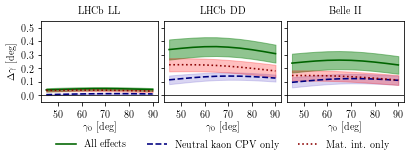

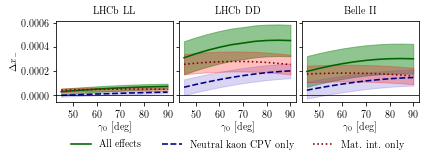

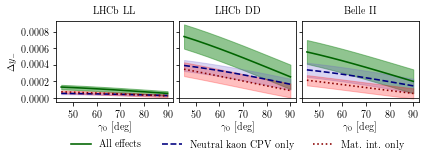

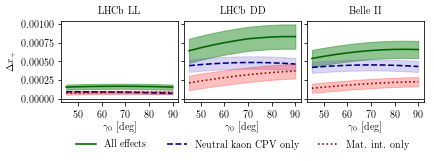

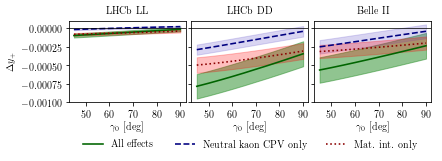

In [18]:

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)    


def make_effect_experiment_comparison_plot(all_results, param, ylabel, ymin = -0.55, ymax = 0.45,ignore_unc=False):
    fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(6.5,1.5))
    fig.subplots_adjust(wspace=0.05)
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    for ie, e in enumerate(experiments):
        results = all_results[(all_results.experiment == e) & (all_results.effect=='full')]
        bias_plot(ax[ie], results, param, 'g_val_deg', ylabel=ylabel, color='g',label='All effects', draw_ylabel=(ie==0), ignore_unc=ignore_unc)
        
        results = all_results[(all_results.experiment == e) & (all_results.effect=='eps_only')]
        bias_plot(ax[ie], results, param, 'g_val_deg', ylabel=ylabel, ls='--',color='b',label='Neutral kaon CPV only', draw_ylabel=(ie==0), ignore_unc=ignore_unc)
        
        results = all_results[(all_results.experiment == e) & (all_results.effect=='mat_only')]
        bias_plot(ax[ie], results, param, 'g_val_deg', ylabel=ylabel, ls=':',color='r',label='Mat. int. only', draw_ylabel=(ie==0), ignore_unc=ignore_unc)
        
        if param == 'g':
            ax[ie].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
            ax[ie].set_ylim(ymin, ymax)
        ax[ie].set_labelsize=10
        ax[ie].axhline(y=0, color='k', lw=0.75)
        ax[ie].set_title(pretty_titles[e], fontsize=10)
    leg = ax[1].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=3)
    plt.savefig('plots/gamma_scan_{}_{}_{}.pdf'.format(default_model, n_KL, param), bbox_extra_artists=[leg,], bbox_inches='tight')
    print 'saving:', 'plots/gamma_scan_{}_{}_{}.pdf'.format(default_model, n_KL, param)
    

make_effect_experiment_comparison_plot(res, 'g', '$\Delta\gamma$ [deg]', ymin = -0.05, ymax = 0.55)
make_effect_experiment_comparison_plot(res, 'xm', '$\Delta x_-$', ymin = -0.05, ymax = 0.55)
make_effect_experiment_comparison_plot(res, 'ym', '$\Delta y_-$', ymin = -0.05, ymax = 0.55)
make_effect_experiment_comparison_plot(res, 'xp', '$\Delta x_+$', ymin = -0.05, ymax = 0.55)
make_effect_experiment_comparison_plot(res, 'yp', '$\Delta y_+$', ymin = -0.05, ymax = 0.55)
# make_comparison_plot('r', 'r',- 0.0005, 0.0005)
# make_comparison_plot('d', '$\delta$', -0.2, 0.2)
# make_comparison_plot('xm', '$x_-$',- 0.002, 0.002)
# make_comparison_plot('ym', '$y_-$',- 0.002, 0.002)
# make_comparison_plot('xp', '$x_+$',- 0.002, 0.002)
# make_comparison_plot('yp', '$y_+$',- 0.002, 0.002)

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=False) 

In [19]:

dfs_delta = []
for e in ['LL_lhcb', 'DD_lhcb', 'VDX_belle']:
    for r in [0.005, 0.1, 0.25]:
        if r == 0.005:
            iv_num = 1
            n_KL = 20
        else:
            iv_num = 0
            n_KL = 50
#     for r in [0.005]:
        print 'loading:',e, r
        dfs_delta.append(load_scan_results('Belle2018', e, q_val = 5, mode='delta_scan', 
                    effect='full', r_val=r,  step_points=25, n_KL=n_KL, iv_num=iv_num))

res_delta = pd.concat(dfs_delta) 



loading: LL_lhcb 0.005
results saved: Thu Mar 28 01:12:49 2019
loading: LL_lhcb 0.1
results saved: Thu Mar 21 05:11:38 2019
loading: LL_lhcb 0.25
results saved: Thu Mar 21 03:54:47 2019
loading: DD_lhcb 0.005
results saved: Thu Mar 28 01:15:25 2019
loading: DD_lhcb 0.1
results saved: Thu Mar 21 03:59:46 2019
loading: DD_lhcb 0.25
results saved: Thu Mar 21 04:01:54 2019
loading: VDX_belle 0.005
results saved: Thu Mar 28 00:49:09 2019
loading: VDX_belle 0.1
results saved: Thu Mar 21 04:02:44 2019
loading: VDX_belle 0.25
results saved: Thu Mar 21 03:54:24 2019


saving: plots/delta_scan_Belle2018_50_g.pdf
saving: plots/delta_scan_Belle2018_50_xm.pdf
saving: plots/delta_scan_Belle2018_50_ym.pdf
saving: plots/delta_scan_Belle2018_50_xp.pdf
saving: plots/delta_scan_Belle2018_50_yp.pdf


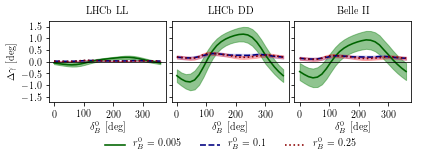

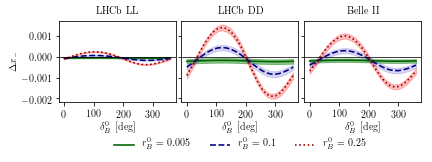

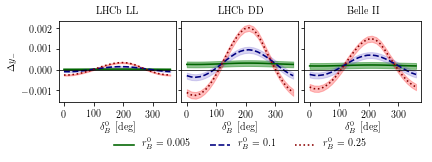

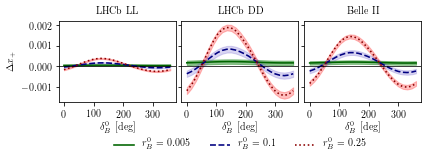

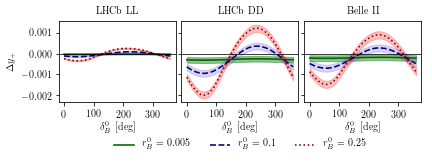

In [20]:
def make_delta_scans_comparison_plot(all_results, rs, param, ylabel,  name = '', ymin = -0.55, ymax = 0.45, ignore_unc=False):
    fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(6.5,1.5))

    fig.subplots_adjust(wspace=0.05)
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    
    colors = ['g','b', 'r', 'o']
    linestyles = ['-','--',':','-']
    for ie, e in enumerate(experiments):
        for color, ls,  r in zip(colors, linestyles, rs):
            results = all_results[(all_results.experiment == e) & (all_results.r_val ==r)]
            bias_plot(ax[ie], results, param, 'd_val_deg', ylabel=ylabel, xlabel = '$\delta_B^0$ [deg]', color=color, ls=ls, label='$r_B^0 = {}$'.format(r), draw_ylabel=(ie==0),ignore_unc=ignore_unc)
        
        if param=='g':
            ax[ie].set_ylim(ymin, ymax)
            ax[ie].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5])
        ax[ie].set_labelsize=10
        ax[ie].axhline(y=0, color='k', lw=0.75)
        ax[ie].set_title(pretty_titles[e], fontsize=10)
    leg = ax[1].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=len(rs))
    plt.savefig('plots/{}delta_scan_{}_{}_{}.pdf'.format(name, default_model, n_KL, param), bbox_extra_artists=[leg,], bbox_inches='tight')
    print 'saving:', 'plots/{}delta_scan_{}_{}_{}.pdf'.format(name, default_model, n_KL, param)

make_delta_scans_comparison_plot(res_delta, [0.005, 0.1, 0.25], 'g', '$\Delta\gamma$ [deg]', ymin = -1.75, ymax = 1.75)
make_delta_scans_comparison_plot(res_delta, [0.005, 0.1, 0.25], 'xm', '$\Delta x_-$', ymin = -1.6, ymax = 1.6)
make_delta_scans_comparison_plot(res_delta, [0.005, 0.1, 0.25], 'ym', '$\Delta y_-$', ymin = -1.6, ymax = 1.6)
make_delta_scans_comparison_plot(res_delta, [0.005, 0.1, 0.25], 'xp', '$\Delta x_+$', ymin = -1.6, ymax = 1.6)
make_delta_scans_comparison_plot(res_delta, [0.005, 0.1, 0.25], 'yp', '$\Delta y_+$', ymin = -1.6, ymax = 1.6)